## Bayesian MCMC algorithm for inference of $N_e$ parameters in MSC model

Note, we have not yet implemented joint inference of divergence time, or $r$, into this method. It should be straight forward, but would extend the run time. For now it takes fixed values for these parameters.

In [73]:
import toyplot
import ipcoal
import numpy as np
from pathlib import Path
import arviz

In [74]:
FIGS = Path("../manuscript/figures/posteriors")
FIGS.mkdir(exist_ok=True)

### Run MCMC algorithm

The Python program `mcmc2.py` is provided in the project repo in the scripts/ directory. Each of these was repeated for four chains from seeds 666, 777, 888 and 999.

One chain of the MS-SMC analysis

In [75]:
# python mcmc2.py \
#   --params 2e5 3e5 4e5 1e6 2e-9 \
#   --priors u,1e5,1e6 u,1e5,1e6 u,1e5,1e6 u,1e5,2e6 u,1e-9,3e-9 \
#   --nsamples 4 \
#   --threads 12 \
#   --seed-trees 555 --seed-mcmc 666 \
#   --mcmc-burnin 500 --mcmc-nsamples 5_000 \
#   --nloci 50 --nsites 4e5 \
#   --smc --smc-event-type combined \
#   --ancestry-model hudson \
#   --name Burg-final-chain1-seed666 \
#   --append

One chain of the MSC analysis

In [76]:
# python mcmc2.py \
#   --params 2e5 3e5 4e5 1e6 2e-9 \
#   --priors u,1e5,1e6 u,1e5,1e6 u,1e5,1e6 u,1e5,2e6 u,1e-9,3e-9 \
#   --nsamples 4 \
#   --threads 12 \
#   --seed-trees 555 --seed-mcmc 777 \
#   --mcmc-burnin 500 --mcmc-nsamples 5_000 \
#   --nloci 50 --nsites 4e5 \
#   --ancestry-model hudson \
#   --name Burg-msc1-final-chain2-seed777 \
#   --msc
#   --append

One chain of the MSC + MS-SMC analysis

In [77]:
# python mcmc2.py \
#   --params 2e5 3e5 4e5 1e6 2e-9 \
#   --priors u,1e5,1e6 u,1e5,1e6 u,1e5,1e6 u,1e5,2e6 u,1e-9,3e-9 \
#   --nsamples 4 \
#   --threads 12 \
#   --seed-trees 555 --seed-mcmc 666 \
#   --mcmc-burnin 500 --mcmc-nsamples 5_000 \
#   --nloci 50 --nsites 4e5 \
#   --ancestry-model hudson \
#   --name Burg-mssmc-final-chain1-seed666 \
#   --smc --smc-event-type combined \
#   --msc --msc-scaler 0.001 \
#   --append

### Load results

In [20]:
BDIR = Path("/mnt/pinky/deren/waiting-distances/batch-scripts/")

In [21]:
# FINAL FOR SMC
arr1 = np.load(BDIR / "Burg-final-chain1-seed666.npy")#[1000:]
arr2 = np.load(BDIR / "Burg-final-chain2-seed777.npy")#[1000:]
arr3 = np.load(BDIR / "Burg-final-chain3-seed888.npy")#[1000:]
arr4 = np.load(BDIR / "Burg-final-chain4-seed999.npy")#[1000:]
arr_smc = np.vstack([arr1, arr2, arr3, arr4])
arr_smc.shape

(13900, 6)

In [22]:
# FINAL FOR MSC
arr1 = np.load(BDIR / "Burg-msc-final-chain1-seed666.npy")#[1000:]
arr2 = np.load(BDIR / "Burg-msc1-final-chain2-seed777.npy")#[1000:]
arr3 = np.load(BDIR / "Burg-msc1-final-chain3-seed888.npy")#[1000:]
arr4 = np.load(BDIR / "Burg-msc1-final-chain4-seed999.npy")#[1000:]
arr_msc = np.vstack([arr1, arr2, arr3, arr4])
arr_msc.shape

(18350, 6)

In [23]:
# FINAL FOR MSC + MS-SMC
arr1 = np.load(BDIR / "Burg-mssmc-final-chain1-seed666.npy")#[1000:]
arr2 = np.load(BDIR / "Burg-mssmc-final-chain2-seed777.npy")#[1000:]
arr3 = np.load(BDIR / "Burg-mssmc-final-chain3-seed888.npy")#[1000:]
arr4 = np.load(BDIR / "Burg-mssmc-final-chain4-seed999.npy")#[1000:]
arr_mssmc = np.vstack([arr1, arr2, arr3, arr4])
arr_mssmc.shape

(12750, 6)

### Plot results

In [24]:
def plot_tau_posterior(arr):
    canvas = toyplot.Canvas(width=225, height=225)
    axes = canvas.cartesian()
    axes.x.domain.show = True
    axes.x.ticks.locator = toyplot.locator.Extended(count=4)#([9.8e6, 9.9e6, 1e6])
    axes.x.ticks.show = True
    axes.x.ticks.near = 7.5
    axes.x.ticks.far = 0
    axes.x.ticks.labels.offset = 12.5
    axes.x.ticks.style['stroke-width'] = 1.5
    axes.x.spine.style['stroke-width'] = 1.5
    
    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    
    # axes.y.ticks.show = False
    axes.y.ticks.labels.show = False
    
    colors = toyplot.color.Palette()
    for idx in [3]:
        data = arr[:, idx] / 1e6
        mags, bars = np.histogram(data, bins=30, density=True)
        bars = bars[1:]
        axes.fill(bars, mags, opacity=0.3, color=colors[idx])
    
        # plot 95% credible interval
        ci95 = arviz.stats.hdi(data, 0.95)
        mask = (ci95[0] < bars) & (ci95[1] > bars)
        axes.fill(bars[mask], mags[mask], opacity=0.5, color=colors[idx])

        # add lines
        axes.plot(bars, mags, style={"stroke-width": 3}, color=colors[idx])

    # add vertical lines at the true value    
    style={"stroke-width": 3, "stroke": toyplot.color.Palette()[3], "stroke-dasharray": "4,4"}
    axes.vlines(1.0, style=style)
    axes.x.domain.max = data.mean() + data.std()
    axes.x.domain.min, axes.x.domain.max = 0.99, 1.01
    #print(data.std())
    return canvas

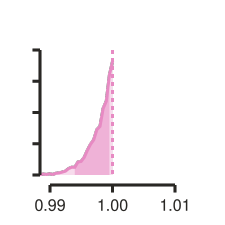

In [25]:
canvas = plot_tau_posterior(arr_smc)
toyplot.svg.render(canvas, str(FIGS / "smc_tau.svg"))
canvas

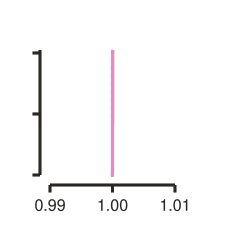

In [26]:
canvas = plot_tau_posterior(arr_msc)
toyplot.svg.render(canvas, str(FIGS / "msc_tau.svg"))
canvas

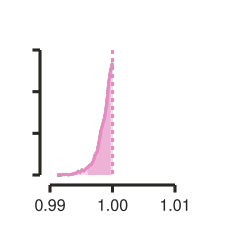

In [27]:
canvas = plot_tau_posterior(arr_mssmc)
toyplot.svg.render(canvas, str(FIGS / "mssmc_tau.svg"))
canvas

In [28]:
def plot_r_posterior(arr):
    canvas = toyplot.Canvas(width=225, height=225)
    axes = canvas.cartesian()
    axes.x.domain.show = True
    axes.x.ticks.locator = toyplot.locator.Extended(count=4)
    axes.x.ticks.show = True
    axes.x.ticks.near = 7.5
    axes.x.ticks.far = 0
    axes.x.ticks.labels.offset = 12.5
    axes.x.ticks.style['stroke-width'] = 1.5
    axes.x.spine.style['stroke-width'] = 1.5
    
    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    
    # axes.y.ticks.show = False
    axes.y.ticks.labels.show = False
    
    colors = toyplot.color.Palette()
    for idx in [4]:
        data = arr[:, idx] * 1e9
        mags, bars = np.histogram(data, bins=30, density=True)
        bars = bars[1:]
        axes.fill(bars, mags, opacity=0.3, color=colors[idx])
    
        # plot 95% credible interval
        ci95 = arviz.stats.hdi(data, 0.95)
        mask = (ci95[0] < bars) & (ci95[1] > bars)
        axes.fill(bars[mask], mags[mask], opacity=0.5, color=colors[idx])

        # add lines
        axes.plot(bars, mags, style={"stroke-width": 3}, color=colors[idx])

    # add vertical lines at the true value    
    style={"stroke-width": 3, "stroke": toyplot.color.Palette()[3], "stroke-dasharray": "4,4"}
    axes.vlines(2.0, style=style)
    axes.x.domain.max = data.mean() + data.std()
    axes.x.domain.min, axes.x.domain.max = 1.9, 2.1
    #print(data.std())
    return canvas

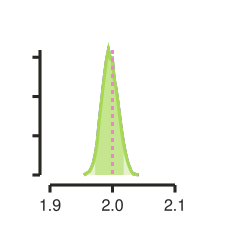

In [29]:
canvas = plot_r_posterior(arr_smc)
toyplot.svg.render(canvas, str(FIGS / "smc_r.svg"))
canvas

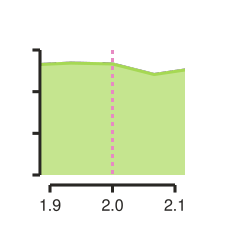

In [30]:
canvas = plot_r_posterior(arr_msc)
toyplot.svg.render(canvas, str(FIGS / "msc_r.svg"))
canvas

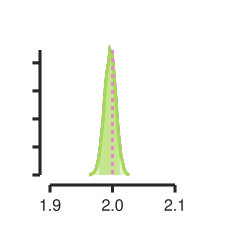

In [31]:
canvas = plot_r_posterior(arr_mssmc)
toyplot.svg.render(canvas, str(FIGS / "mssmc_r.svg"))
canvas

In [37]:
def plot_ne_posteriors(arr):
    canvas = toyplot.Canvas(width=450, height=225)
    axes = canvas.cartesian()
    axes.x.domain.show = True
    axes.x.ticks.locator = toyplot.locator.Extended(count=5, only_inside=True)
    axes.x.ticks.show = True
    axes.x.ticks.near = 7.5
    axes.x.ticks.far = 0
    axes.x.ticks.labels.offset = 12.5
    axes.x.ticks.style['stroke-width'] = 1.5
    axes.x.spine.style['stroke-width'] = 1.5
    
    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    
    # axes.y.ticks.show = False
    axes.y.ticks.labels.show = False
    
    colors = toyplot.color.Palette()
    for idx in [0, 1, 2]:
        
        mags, bars = np.histogram(arr[:, idx], bins=30, density=True)
        bars = bars[1:]
        axes.fill(bars, mags, opacity=0.3, color=colors[idx])
    
        # plot 95% credible interval
        ci95 = arviz.stats.hdi(arr[:, idx], 0.95)
        mask = (ci95[0] < bars) & (ci95[1] > bars)
        axes.fill(bars[mask], mags[mask], opacity=0.5, color=colors[idx])
            
        # add lines
        axes.plot(bars, mags, style={"stroke-width": 3})
    
        
    # add vertical lines at the true value    
    for nidx, neff in enumerate([200000, 300000, 400000]):
        style={"stroke-width": 3, "stroke": toyplot.color.Palette()[nidx], "stroke-dasharray": "4,4"}
        axes.vlines(neff, style=style)
    axes.x.domain.min = 150_000
    axes.x.domain.max = 525_000
    return canvas

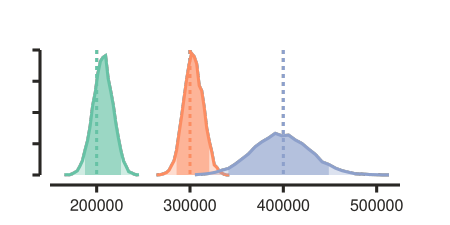

In [38]:
canvas = plot_ne_posteriors(arr_smc)
toyplot.svg.render(canvas, str(FIGS / "smc_ne.svg"))
canvas

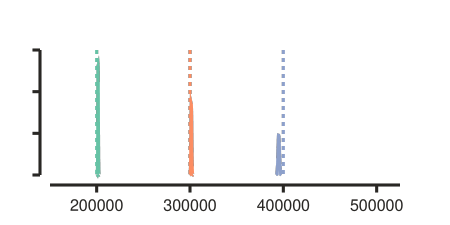

In [39]:
canvas = plot_ne_posteriors(arr_msc)
toyplot.svg.render(canvas, str(FIGS / "msc_ne.svg"))
canvas

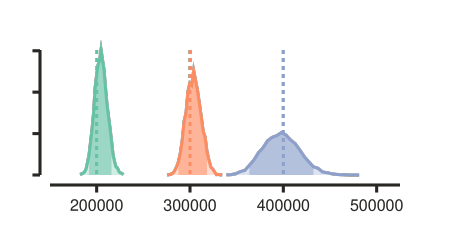

In [40]:
canvas = plot_ne_posteriors(arr_mssmc)
toyplot.svg.render(canvas, str(FIGS / "mssmc_ne.svg"))
canvas

### Examine posteriors with Arviz

In [41]:
# below here requires arviz, used for diagnostic examination of MCMC chain
import arviz
arviz.style.use("arviz-darkgrid")

In [67]:
BURNIN = 0
arr = arr_smc
adata = arviz.convert_to_inference_data({
    "Ne1": arr[BURNIN:, 0],
    "Ne2": arr[BURNIN:, 1],
    "Ne3": arr[BURNIN:, 2],
    "Tau": arr[BURNIN:, 3],
    "r": arr[BURNIN:, 4] * 1e9,
    "loglik": arr[BURNIN:, 5],
})
x = arviz.summary(adata, hdi_prob=0.95)
x

arviz - WARNING - Shape validation failed: input_shape: (1, 13900), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne1,205411.357,10709.404,185313.265,227277.441,321.245,227.214,1115.0,2154.0,NaN
Ne2,302365.766,10384.731,283013.425,323220.544,271.660,194.057,1471.0,3128.0,NaN
Ne3,394418.674,30385.690,335546.541,454667.545,1087.174,769.035,779.0,1741.0,NaN
Tau,997744.593,2075.697,993533.248,1000013.484,41.693,29.485,2511.0,2674.0,NaN
r,1.995,0.013,1.971,2.021,0.001,0.000,609.0,1577.0,NaN
loglik,1330318.168,1.705,1330315.450,1330321.531,0.036,0.025,2520.0,3933.0,NaN


In [68]:
# zscores
(x["mean"].values[:5] - np.array([2e5, 3e5, 4e5, 1e6, 2])) / x["sd"].values[:5]

array([ 0.50529021,  0.22781197, -0.18368271, -1.08657815, -0.38461538])

In [69]:
BURNIN = 0
arr = arr_msc
adata = arviz.convert_to_inference_data({
    "Ne1": arr[BURNIN:, 0],
    "Ne2": arr[BURNIN:, 1],
    "Ne3": arr[BURNIN:, 2],
    "Tau": arr[BURNIN:, 3],
    "r": arr[BURNIN:, 4] * 1e9,
    "loglik": arr[BURNIN:, 5],
})
x = arviz.summary(adata, hdi_prob=0.95)
x

arviz - WARNING - Shape validation failed: input_shape: (1, 18350), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne1,2.014933e+05,297.678,2.009031e+05,2.020621e+05,2.920,2.065,10424.0,11528.0,NaN
Ne2,3.013875e+05,458.852,3.004932e+05,3.022825e+05,5.134,3.631,7981.0,10465.0,NaN
Ne3,3.949907e+05,810.060,3.933815e+05,3.965594e+05,8.389,5.932,9324.0,10614.0,NaN
Tau,1.000010e+06,3.841,1.000003e+06,1.000014e+06,0.102,0.072,1684.0,1673.0,NaN
r,1.997000e+00,0.571,1.000000e+00,2.892000e+00,0.006,0.004,9725.0,13713.0,NaN
loglik,1.597140e+07,1.722,1.597140e+07,1.597141e+07,0.034,0.025,2754.0,3860.0,NaN


In [70]:
# zscores
(x["mean"].values[:5] - np.array([2e5, 3e5, 4e5, 1e6, 2])) / x["sd"].values[:5]

array([ 5.01649097e+00,  3.02390531e+00, -6.18388761e+00,  2.70372299e+00,
       -5.25394046e-03])

In [71]:
BURNIN = 0
arr = arr_mssmc
adata = arviz.convert_to_inference_data({
    "Ne1": arr[BURNIN:, 0],
    "Ne2": arr[BURNIN:, 1],
    "Ne3": arr[BURNIN:, 2],
    "Tau": arr[BURNIN:, 3],
    "r": arr[BURNIN:, 4] * 1e9,
    "loglik": arr[BURNIN:, 5],
})
x = arviz.summary(adata, hdi_prob=0.95)
x

arviz - WARNING - Shape validation failed: input_shape: (1, 12750), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne1,203889.556,6871.898,190346.845,217107.624,146.500,103.664,2208.0,4540.0,NaN
Ne2,302829.873,8180.883,287281.618,318942.372,146.228,103.524,3142.0,5844.0,NaN
Ne3,395274.795,19390.905,359730.093,434695.125,550.644,389.613,1245.0,2608.0,NaN
Tau,998605.892,1272.393,996014.089,1000013.419,33.713,23.844,1546.0,2139.0,NaN
r,1.995,0.009,1.978,2.013,0.000,0.000,1170.0,2467.0,NaN
loglik,1346289.620,1.687,1346286.975,1346292.983,0.031,0.022,3094.0,5261.0,NaN


In [72]:
# zscores
(x["mean"].values[:5] - np.array([2e5, 3e5, 4e5, 1e6, 2])) / x["sd"].values[:5]

array([ 0.56600898,  0.3459129 , -0.24368151, -1.09565834, -0.55555556])

In [615]:
# arviz.plot_trace(adata);

In [616]:
# arviz.plot_trace(np.expand_dims(arr[:, :3], 0), figsize=(7, 2));

### 50% credible interval

In [617]:
# arviz.plot_posterior(np.expand_dims(arr[0:, :3], 0), figsize=(15, 3), hdi_prob=0.5);

### 95% credible interval

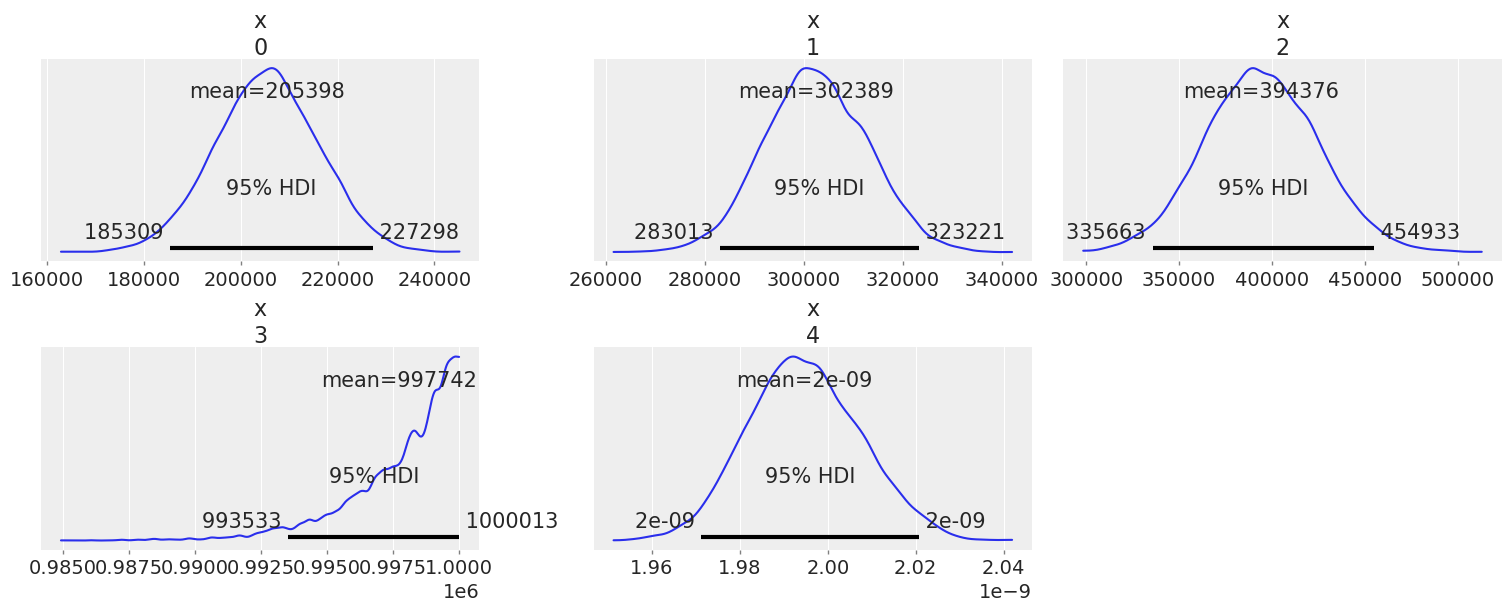

In [620]:
arviz.plot_posterior(np.expand_dims(arr[0:, :5], 0), figsize=(15, 6), hdi_prob=0.95);

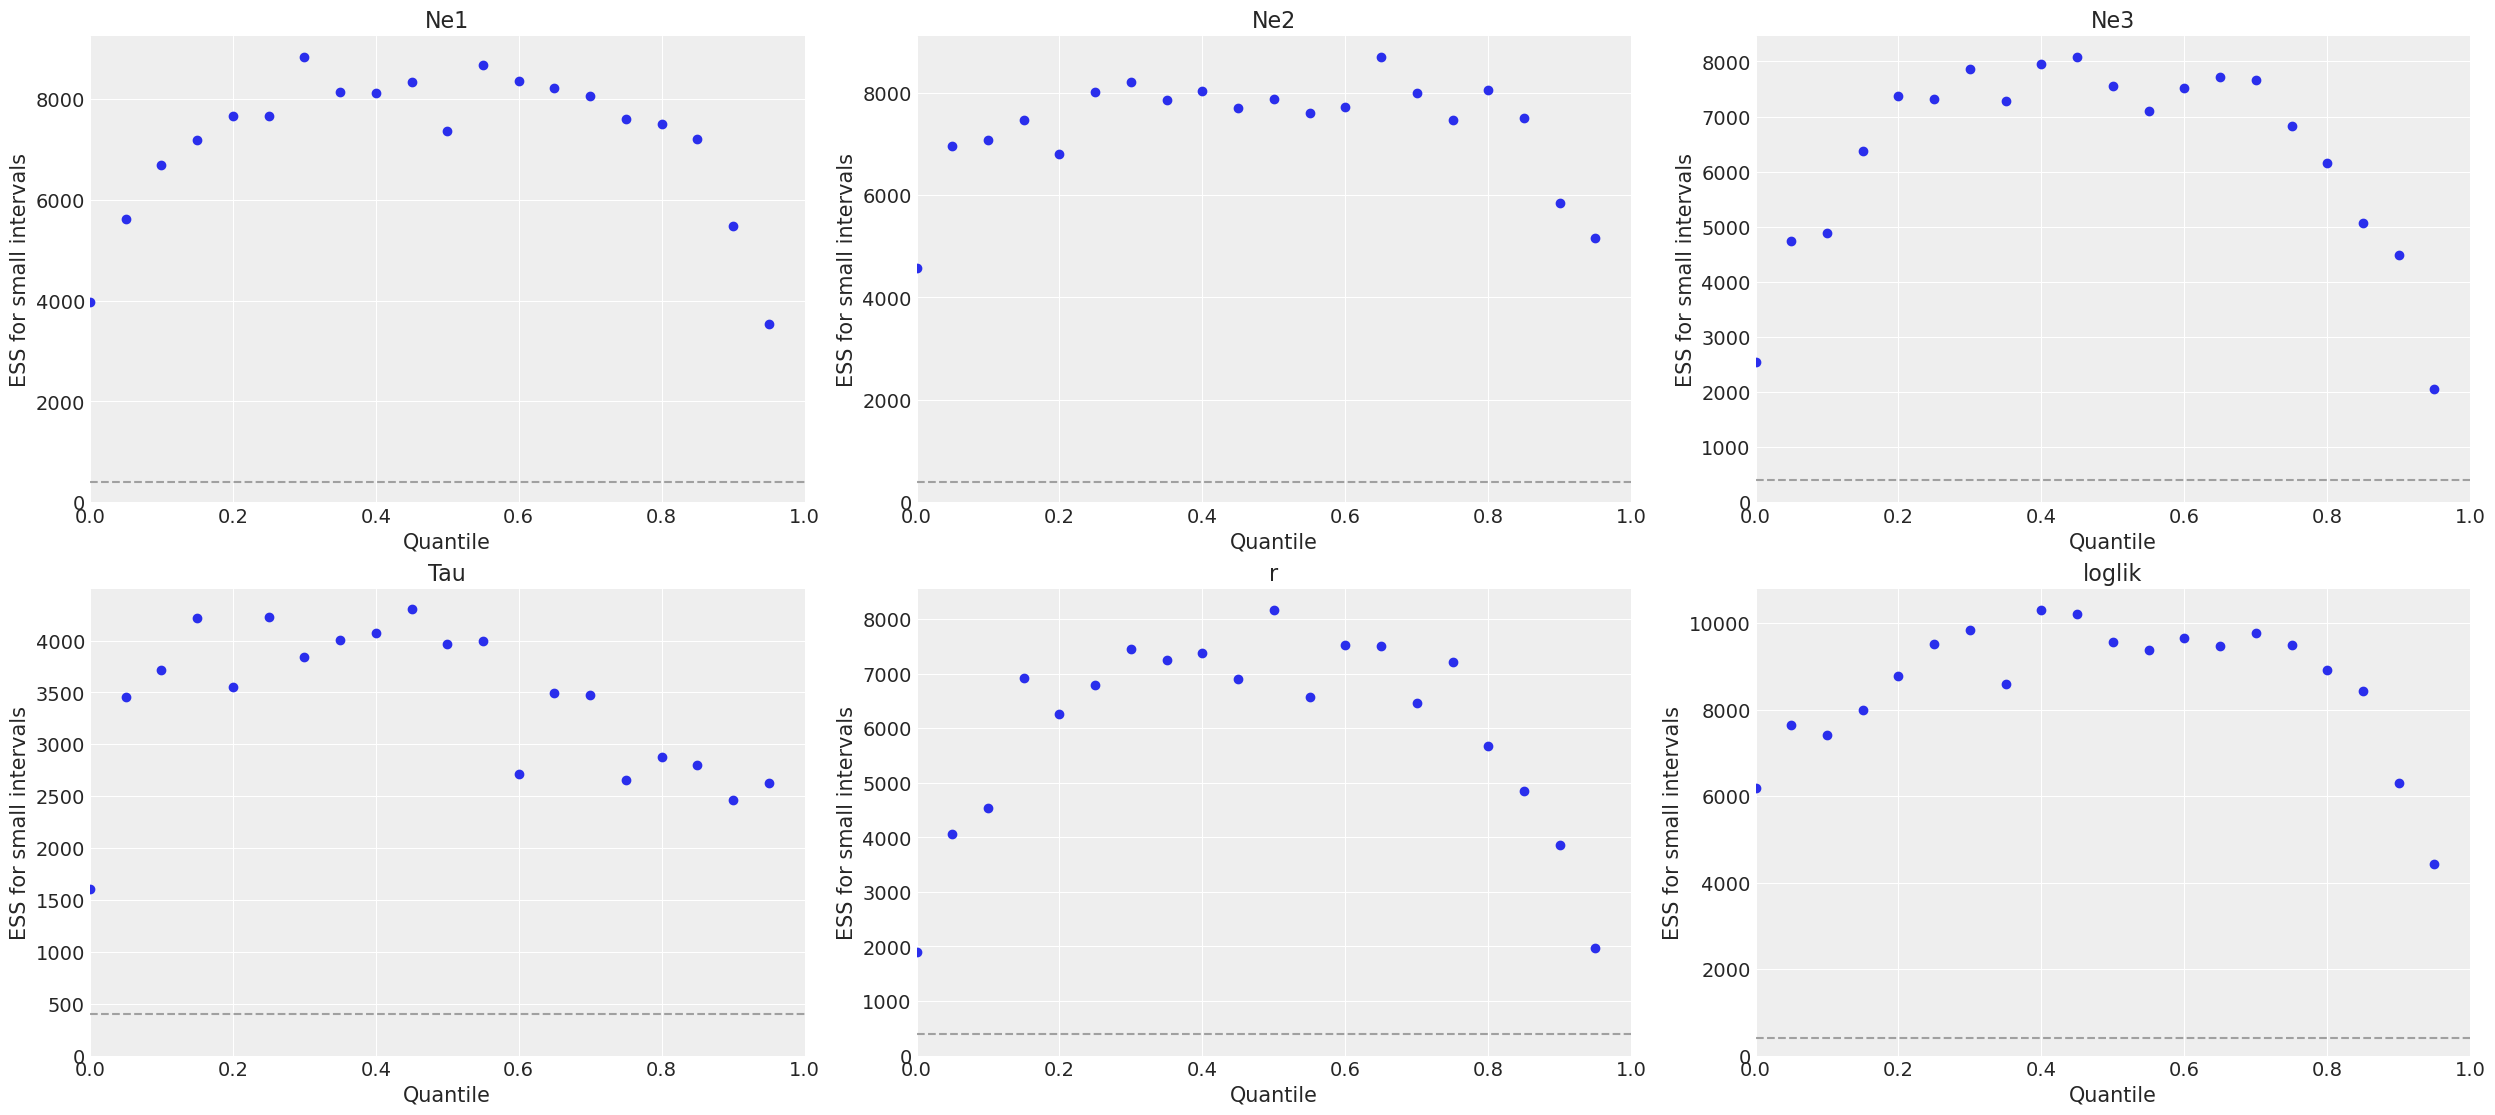

In [375]:
arviz.plot_ess(adata);